# 3DMNN
#### EXPERIMENTS

In [1]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper, generate_mitsuba_xml

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

class_name = input('Give me the class name (e.g. "chair"): ').lower()

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)


# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 100,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))

# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()

ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 70, verbose=False)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

Give me the class name (e.g. "chair"): car
<generator object files_in_subdirs at 0x7f66a4ce6360>
7497 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-70


Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [2]:
print(all_pc_data.point_clouds[-1].shape)

import random as rd

from_int = rd.randint(0, 4000)
to_int = rd.randint(0, 4000)

reconstruction_from = np.asarray(ae.reconstruct(all_pc_data.point_clouds[from_int].reshape(1,2048,3)))
reconstruction_to = np.asarray(ae.reconstruct(all_pc_data.point_clouds[to_int].reshape(1,2048,3)))

#data for the latent gan
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    print(_from.shape)
    print(_to.shape)
    
    interpolations = ae.interpolate(_from, _to, steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)
        generate_mitsuba_xml(interpolation, class_name, i)
        
    print("Interpolation Complete")
    print(interpolations.shape)
    
interpolate(reconstruction_from[0], reconstruction_to[0], steps=60)

(2048, 3)
Generating interpolations
(1, 2048, 3)
(1, 2048, 3)
Interpolation Complete
(62, 2048, 3)


Create and Configure GAN...

In [3]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(7497, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


1 (-12.840298320623052, -2.606257941298837)
INFO:tensorflow:./models_checkpoints/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (-15.991964749841882, -5.27280813895616)
3 (-14.310132973946182, -6.1964395382260316)
4 (-12.545863087545305, -6.911734686601882)
5 (-10.774107504211017, -7.273678507580853)
INFO:tensorflow:./models_checkpoints/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.
6 (-9.174278720113255, -7.127247944774243)
7 (-7.794225315119596, -6.3371670166118035)
8 (-6.729685520965781, -5.077668484425384)
9 (-5.948869810808425, -3.454729222611293)
10 (-5.3662557153893795, -1.807869590768878)
INFO:tensorflow:./models_checkpoints/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
11 (-4.991487368641284, -0.25343601272524263)
12 (-4.727062910195165, 0.9690199452358604)
13 (-4.516924701281042, 1.9530475499645976)
14 (-4.395812495442845, 2.5997417885185086)
15 (-4.259308635788476, 3.035745084685767)
16 (-4.137784

166 (-0.8601390463393807, -0.44055125307316745)
167 (-0.842185197660587, -0.43571123090766417)
168 (-0.8272820159092845, -0.38862375655030246)
169 (-0.8356444651648502, -0.38948610074968143)
170 (-0.8155393920488806, -0.3512024764446604)
171 (-0.8337741486178148, -0.3958309541812679)
172 (-0.8537528246841175, -0.33325930719807645)
173 (-0.8053350028575667, -0.40751408210536777)
174 (-0.8240087612363316, -0.3639362897448892)
175 (-0.832523145531648, -0.3614503725263096)
176 (-0.8317372578902532, -0.3084685588443039)
177 (-0.8304500711844272, -0.32868780558241295)
178 (-0.818326542441477, -0.3503077707234645)
179 (-0.8339883277080203, -0.3315149402658411)
180 (-0.8256244235390785, -0.3618859277175577)
181 (-0.8471560630222295, -0.374760050701615)
182 (-0.8227960443336692, -0.3723126509845657)
183 (-0.8166668799099506, -0.37962109750549267)
184 (-0.834867749838221, -0.3426507117864269)
185 (-0.8156782876725165, -0.365388846437403)
186 (-0.8072334952002403, -0.3482986574104968)
187 (-0.822

332 (-0.6772281995555699, -0.022974509024393318)
333 (-0.6835567145139579, -0.02336173473221356)
334 (-0.6771269920688348, 0.02394181241800121)
335 (-0.68054612210933, -0.024022924781764463)
336 (-0.6798944245248832, -0.037718224339187145)
337 (-0.6836097356457038, 0.026149950458999448)
338 (-0.6714607613198709, -0.02804625901274833)
339 (-0.673897649217772, 0.019811527701139673)
340 (-0.6818993853642636, 0.06284687400876776)
341 (-0.6827361281686182, 0.006889856307948595)
342 (-0.6740453835301752, 0.02550984784373201)
343 (-0.6803407485053043, -0.010948269536184309)
344 (-0.6802831704184513, 0.03396405965002291)
345 (-0.6783171784157721, 0.006181229140895463)
346 (-0.6715322540910452, -0.03533614720077247)
347 (-0.6775890888783755, 0.006991335911811649)
348 (-0.6875124765722543, -0.011897822154448337)
349 (-0.6795549898739629, -0.019839748118272764)
350 (-0.6749269714291464, -0.04708913676034434)
INFO:tensorflow:./models_checkpoints/models.ckpt-350 is not in all_model_checkpoint_paths

498 (-0.6077518897168588, 0.0776922708414745)
499 (-0.6048330496621612, 0.03004460501790847)
500 (-0.6113375151317392, 0.03426435420128685)
INFO:tensorflow:./models_checkpoints/models.ckpt-500 is not in all_model_checkpoint_paths. Manually adding it.
501 (-0.6084190767083392, 0.03248255477980679)
502 (-0.6133531632039371, 0.07906475105172886)
503 (-0.6060541632191446, 0.06102065846398973)
504 (-0.601021691056706, 0.04531553533903304)
505 (-0.6063323504972777, 0.05550427792043794)
506 (-0.6073923767013037, 0.03702449070480371)
507 (-0.6095459843241928, 0.05772286440064543)
508 (-0.5939387487085074, 0.07641803204463232)
509 (-0.6073400264218349, 0.0768336916229869)
510 (-0.6114352167452741, 0.03995567227213279)
511 (-0.6154899125131185, 0.04450176379779329)
512 (-0.6038024723529816, 0.06203750068721855)
513 (-0.6021271736029811, 0.06048423658834533)
514 (-0.6045031393534385, 0.03472577442958851)
515 (-0.6055130066487613, 0.06365595843475749)
516 (-0.6037491329964375, 0.022745633711913387

664 (-0.5856316497661923, 0.030922631240112318)
665 (-0.579951794155492, 0.041635451332865996)
666 (-0.5704901544439712, 0.06898449405702768)
667 (-0.5876194278665837, 0.03430384445635464)
668 (-0.5813264476772922, 0.052067431423581834)
669 (-0.5791507511330931, 0.05534282516127127)
670 (-0.5827970006721932, 0.024107912812778888)
671 (-0.5792525756679126, 0.033765412142794056)
672 (-0.5786735065431403, 0.029000270620086886)
673 (-0.5792277023296228, 0.07274550607665473)
674 (-0.5792264064286379, 0.0012308954661274516)
675 (-0.5737774974147746, 0.0216071277500549)
676 (-0.5820396600553653, 0.050047879754221876)
677 (-0.5764225901373281, 0.020429396333060408)
678 (-0.5812316984938295, 0.015554349203812795)
679 (-0.5815415760414713, 0.03968990233261138)
680 (-0.576631908248735, 0.05705195990072301)
681 (-0.5753435094484547, 0.014618544147081122)
682 (-0.5787043355455335, 0.04066432096281295)
683 (-0.5748162521611924, 0.011420663475828954)
684 (-0.5754566502651112, 0.011831806611657242)
68

829 (-0.556435484214117, -0.14982793312957324)
830 (-0.5462114280902299, -0.19206321929525208)
831 (-0.5519031456252873, -0.1698896760158491)
832 (-0.5495663163245924, -0.19284887776878856)
833 (-0.551729865322177, -0.17021801697727817)
834 (-0.5513674134776096, -0.16293400073511488)
835 (-0.5517556753334583, -0.16324108991546918)
836 (-0.5521522660383442, -0.1650671185863098)
837 (-0.5486273999582201, -0.18106650486088438)
838 (-0.5515948053974433, -0.14935848546908206)
839 (-0.5559009001559059, -0.17288283538698349)
840 (-0.5541546042733545, -0.1788367588548052)
841 (-0.5508895740413026, -0.17570315916466234)
842 (-0.5553834160302309, -0.18351267848238847)
843 (-0.5510774924851104, -0.1848016749292412)
844 (-0.5496731134469077, -0.1386518615154212)
845 (-0.5531052116979689, -0.19930907893900904)
846 (-0.5527257351267257, -0.18635049290234698)
847 (-0.5475791850746078, -0.20930844865389317)
848 (-0.5518017663251633, -0.17812279896848154)
849 (-0.5494387569843523, -0.16755327382343727)

995 (-0.517527429049447, -0.43879092439709094)
996 (-0.5225179919460475, -0.4221210213715598)
997 (-0.5212718128357958, -0.4409513277495467)
998 (-0.5123910121869721, -0.4273692653483192)
999 (-0.5207428324142559, -0.4502444429285574)
1000 (-0.5149102923054023, -0.46504552232339075)
INFO:tensorflow:./models_checkpoints/models.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.


/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


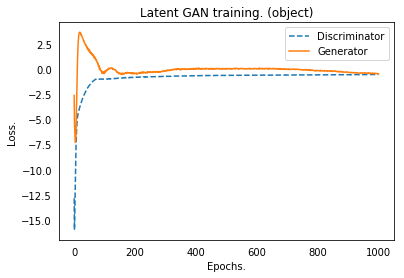

In [4]:
accum_syn_data = []
train_stats = []
n_epochs = 1000
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [5]:
syn_latent_data = gan.generate(5, params["noise_params"])
syn_data = ae.decode(syn_latent_data)
print(syn_data.shape)

reconstruct_obj(syn_data)
for data in syn_data:
    generate_mitsuba_xml(data, class_name + "_gen", 0)


(5, 2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed


# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again